In [ ]:
import pandas_datareader as pdr
import numpy
import os
import math

In [ ]:
df=pdr.get_data_tiingo('AAPL',api_key='94c9039016045dbf8cb2082451d520c3e00cbab6')

In [ ]:
df.to_csv('AAPL.csv')

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('AAPL.csv')

In [ ]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-03-21 00:00:00+00:00,105.91,107.65,105.1401,105.93,35502678,24.622670,25.027197,24.443679,24.627320,142010712,0.0,1.0
1,AAPL,2016-03-22 00:00:00+00:00,106.72,107.29,105.2100,105.25,32444375,24.810984,24.943502,24.459930,24.469229,129777500,0.0,1.0
2,AAPL,2016-03-23 00:00:00+00:00,106.13,107.07,105.9000,106.48,25703495,24.673817,24.892355,24.620345,24.755188,102813980,0.0,1.0
3,AAPL,2016-03-24 00:00:00+00:00,105.67,106.25,104.8900,105.47,26132955,24.566873,24.701716,24.385534,24.520376,104531820,0.0,1.0
4,AAPL,2016-03-28 00:00:00+00:00,105.19,106.19,105.0600,106.00,19411372,24.455280,24.687767,24.425057,24.643594,77645488,0.0,1.0


In [ ]:
df.shape

(1259, 14)

In [ ]:
df1=df.reset_index()['close']

In [ ]:
df1.shape

(1259,)

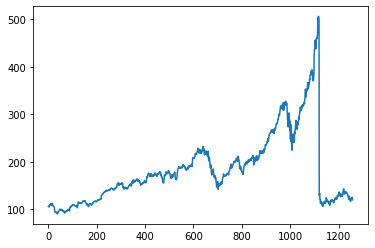

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
#LSTM are sensitive to the scale of data, so using MinMax Scaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
#splititng the dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size ,:],df1[training_size:len(df1),:1]

In [ ]:
def create_dataset(dataset,time_step=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]      #i=0   0,1,2,3...99   100
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return numpy.array(dataX),numpy.array(dataY)  

In [ ]:
time_step=100
X_train,Y_train=create_dataset(train_data,time_step)
X_test,Y_test=create_dataset(test_data,time_step)

In [ ]:
print(X_train)

[[0.03745039 0.03939868 0.03797956 ... 0.04336741 0.04442574 0.04247745]
 [0.03939868 0.03797956 0.03687312 ... 0.04442574 0.04247745 0.04230908]
 [0.03797956 0.03687312 0.03571858 ... 0.04247745 0.04230908 0.0429104 ]
 ...
 [0.15143716 0.15292844 0.14999399 ... 0.25128082 0.24978954 0.24969333]
 [0.15292844 0.14999399 0.16216476 ... 0.24978954 0.24969333 0.24630186]
 [0.14999399 0.16216476 0.15865304 ... 0.24969333 0.24630186 0.24906795]]


In [ ]:
print(X_train.shape)

(717, 100)


In [ ]:
print(Y_train.shape)

(717,)


In [ ]:
#reshape input to [samples,timesteps,features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [ ]:
X_train.shape

(717, 100, 1)

In [ ]:
#Creating the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM 

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
 model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),batch_size=64,epochs=100,verbose=1)

Epoch 1/100
12/12 [==============================] - 36s 123ms/step - loss: 0.0187 - val_loss: 0.0452
Epoch 2/100
12/12 [==============================] - 0s 23ms/step - loss: 0.0028 - val_loss: 0.0255
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0259
Epoch 4/100
12/12 [==============================] - 0s 19ms/step - loss: 7.0853e-04 - val_loss: 0.0208
Epoch 5/100
12/12 [==============================] - 0s 19ms/step - loss: 5.3355e-04 - val_loss: 0.0200
Epoch 6/100
12/12 [==============================] - 0s 18ms/step - loss: 4.3088e-04 - val_loss: 0.0194
Epoch 7/100
12/12 [==============================] - 0s 18ms/step - loss: 4.1610e-04 - val_loss: 0.0190
Epoch 8/100
12/12 [==============================] - 0s 18ms/step - loss: 4.0812e-04 - val_loss: 0.0187
Epoch 9/100
12/12 [==============================] - 0s 18ms/step - loss: 4.1769e-04 - val_loss: 0.0182
Epoch 10/100
12/12 [==============================] - 0s 18ms/step - loss:

In [ ]:
## predicting and checking the performance of the model
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
#Transformback to the orignal form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
# train data RMSE
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train,train_predict))

167.4035680380545

In [ ]:
# test data RMSE
math.sqrt(mean_squared_error(Y_test,test_predict))

255.9934470596738

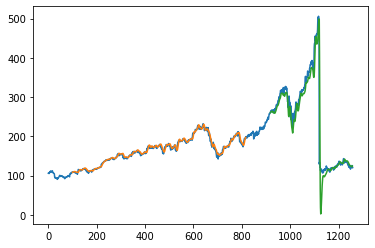

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
test_data.shape

(441, 1)

In [ ]:
#predicting the output for next 100 days
X_input=test_data[341:].reshape(1,-1)
X_input.shape

(1, 100)

In [ ]:
temp_input=list(X_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,X_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = X_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)


[0.08280092]
101
1 day input [[0.05943476 0.06316296 0.05017438 0.06008419 0.044546   0.04432952
  0.04834636 0.05919423 0.06900782 0.06819002 0.06248948 0.06164762
  0.07011425 0.06944077 0.06956103 0.07206254 0.06987372 0.06660253
  0.06806975 0.06494287 0.05654841 0.05972339 0.06179194 0.06313891
  0.06905592 0.07788334 0.07874925 0.07841251 0.07675286 0.08036079
  0.08187613 0.07562237 0.0791341  0.0771377  0.07562237 0.09029465
  0.09012628 0.09226699 0.08734817 0.0911365  0.09991581 0.09770295
  0.10013229 0.11148527 0.10710764 0.10434155 0.1018641  0.09397474
  0.09782321 0.08721587 0.09760673 0.10032471 0.09294047 0.09250752
  0.09753458 0.0927721  0.08851473 0.09017438 0.10027661 0.11191822
  0.11720986 0.12647023 0.1270475  0.12440168 0.11244738 0.10010824
  0.10535177 0.10739627 0.10487072 0.11316897 0.11165364 0.11201443
  0.10984967 0.10835839 0.10773301 0.10831028 0.10306675 0.09741431
  0.09469633 0.09508118 0.0857727  0.08543596 0.08420926 0.07372219
  0.07437162 0.0900

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df1)

1259

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)

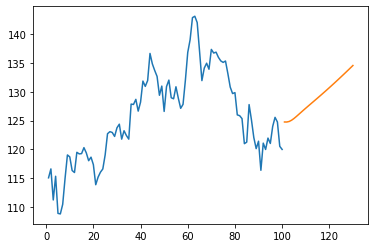

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1159:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))